#### Učitavanje baze i pretprocesiranje

In [3]:
import json
import flair.datasets
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from flair.data import Sentence
from flair.data import Corpus
from flair.embeddings import WordEmbeddings, FlairEmbeddings, StackedEmbeddings
from flair.models import SequenceTagger
from flair.trainers import ModelTrainer
from sklearn import metrics
from flair.datasets import ColumnCorpus

corpus = flair.datasets.UD_SERBIAN().downsample(0.4)

2022-08-30 23:30:50,557 Reading data from C:\Users\vladimir\.flair\datasets\ud_serbian
2022-08-30 23:30:50,557 Train: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-train.conllu
2022-08-30 23:30:50,557 Dev: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-dev.conllu
2022-08-30 23:30:50,558 Test: C:\Users\vladimir\.flair\datasets\ud_serbian\sr_set-ud-test.conllu


In [10]:
a = corpus.obtain_statistics()
print(a)

{
    "TRAIN": {
        "dataset": "TRAIN",
        "total_number_of_documents": 333,
        "number_of_documents_per_class": {
            "\"": 117,
            "trenutan": 4,
            "politi\u010dki": 12,
            "establi\u0161ment": 1,
            "staviti": 1,
            "pod": 7,
            "potpun": 2,
            "kontrola": 5,
            "svaki": 7,
            "slobodan": 1,
            "misao": 1,
            "i": 193,
            "mi\u0161ljenje": 2,
            "koji": 81,
            "biti": 421,
            "protiv": 11,
            "on": 35,
            ".": 304,
            "PUNCT": 954,
            "ADJ": 928,
            "NOUN": 1951,
            "VERB": 671,
            "ADP": 778,
            "DET": 303,
            "CCONJ": 244,
            "AUX": 461,
            "PRON": 197,
            "Z": 955,
            "Agpmsny": 69,
            "Ncmsn": 173,
            "Vmf3s": 4,
            "Sa": 223,
            "Agpfsay": 59,
            "Ncfsa": 139,
  

In [7]:
# Ispisujemo broj recenica u svakom u podeli skupova
print("Training: ",len(corpus.train))
print("Test: ",len(corpus.test))
print("Dev: ",len(corpus.dev))

Training:  333
Test:  52
Dev:  54


### Pretprocesiranje podataka
Pošto podaci za treniranje UPOS tagger-a moraju biti u tačno određenom formatu, jedini korak neophodan u pretprocesiranju je da dodelimo svakoj reči UPOS tag ako ga ona već nema. Odnosno ako tag nije u pravilnom formatu, dodeljujemo joj tag "X". UPOS tag "X" označava da se radi o "other" tipu reči, pošto ne možemo da zaključimo ništa više o samoj reči bez njene dalje analize.

In [1]:
for sentence in corpus.get_all_sentences():
    for token in sentence:
        if not token.get_labels('upos'):
            token.add_label('upos','X',1.0)

NameError: name 'corpus' is not defined

### Prikaz učitane recenice i etiketiranih rečeničnih tokena iz validacionog skupa korpusa

In [22]:
sentence = corpus.dev[1]
print(sentence)
for token in sentence:
    print(token)

Sentence: "Sejdiu kaže da je , iz ove perspektive , proces " bio prenagljen … bez plana za ekonomski razvoj " i da je privatizacija dovela do velikih problema za radnike ." → ["Sejdiu"/Sejdiu/PROPN/Npmsn/nsubj/Nom/Masc/Sing, "kaže"/kazati/VERB/Vmr3s/root/Ind/Sing/3/Pres/Fin, "da"/da/SCONJ/Cs/mark, "je"/biti/AUX/Var3s/aux/Ind/Sing/3/Pres/Fin, ","/,/PUNCT/Z/punct, "iz"/iz/ADP/Sg/case/Gen, "ove"/ovaj/DET/Pd-fsg/det/Gen/Fem/Sing/Dem, "perspektive"/perspektiva/NOUN/Ncfsg/obl/Gen/Fem/Sing, ","/,/PUNCT/Z/punct, "proces"/proces/NOUN/Ncmsn/nsubj/Nom/Masc/Sing, """/"/PUNCT/Z/punct, "bio"/biti/AUX/Vap-sm/cop/Masc/Sing/Past/Part/Act, "prenagljen"/prenagliti/ADJ/Appmsnn/ccomp/Nom/Ind/Pos/Masc/Sing/Part/Pass, "…"/…/PUNCT/Z/punct, "bez"/bez/ADP/Sg/case/Gen, "plana"/plan/NOUN/Ncmsg/conj/Gen/Masc/Sing, "za"/za/ADP/Sa/case/Acc, "ekonomski"/ekonomski/ADJ/Agpmsayn/amod/Inan/Acc/Def/Pos/Masc/Sing, "razvoj"/razvoj/NOUN/Ncmsan/nmod/Inan/Acc/Masc/Sing, """/"/PUNCT/Z/punct, "i"/i/CCONJ/Cc/cc, "da"/da/SCONJ/Cs/

### UPOS etikete:
- ADJ: pridev
- ADP: apozicija
- ADV: prilog
- AUX: pomoćni glagoli
- CCONJ: naporedni veznici
- DET: odrednice
- INTJ: uzvici
- NOUN: imenice
- NUM: brojevi
- PART: frazalni glagoli
- PRON: zamenica
- PROPN: vlastite imenice
- PUNCT: znakovi interpunkcije
- SCONJ: zavisni veznik
- SYM: simboli
- VERB: glagoli
- X: ostalo

In [23]:
# Pravljenje rečnika  sa UPOS etiketama iz korpusa
label_type = 'upos'
label_dict  = corpus.make_label_dictionary(label_type = label_type)
print(label_dict)

2022-08-29 22:38:57,704 Computing label dictionary. Progress:


333it [00:00, 25614.89it/s]

2022-08-29 22:38:57,731 Dictionary created for label 'upos' with 17 values: NOUN (seen 1766 times), PUNCT (seen 934 times), ADJ (seen 834 times), ADP (seen 712 times), VERB (seen 624 times), PROPN (seen 499 times), AUX (seen 457 times), DET (seen 321 times), ADV (seen 270 times), CCONJ (seen 255 times), SCONJ (seen 254 times), PRON (seen 202 times), NUM (seen 86 times), PART (seen 57 times), X (seen 19 times), INTJ (seen 1 times)
Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, ADV, CCONJ, SCONJ, PRON, NUM, PART, X, INTJ


### Nagomilana ugnjezdavanja
Više različitih ugnjezdavanja je moguće koristiti istovremeno pomoću `StackedEmbeddings` klase iz `Flair`-a. U našem primeru iskoristili smo:
1. `GloVe` ugnjezdavanja - bazira se na nalaženju korelacije izmedju parova reči na osnovu frekvencije korišćenja u tandemu
2. `Flair` ugnjezdavanja - embedding koji su razvili tvorci `Flair` biblioteke

In [24]:
embedding_types = [
    WordEmbeddings('glove'),
    FlairEmbeddings('news-forward'),
    FlairEmbeddings('news-backward'),
]

embeddings = StackedEmbeddings(embeddings=embedding_types)

### Klasa za etiketiranje (`Tagger`)
Na osnovu kombinacije navedenih ugnjezdavanja generišemo `SequenceTagger` koji ćemo koristiti da na osnovu dobijenih vektorskih reprezentacija reči predvidimo UPOS etikete korespondirajuće reči.

In [25]:
tagger = SequenceTagger(hidden_size=256,
                        embeddings=embeddings,
                        tag_dictionary=label_dict,
                        tag_type=label_type,
                        use_crf=True)

2022-08-29 22:39:10,346 SequenceTagger predicts: Dictionary with 17 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, ADV, CCONJ, SCONJ, PRON, NUM, PART, X, INTJ


### Treniranje modela i traženje optimalnih hiperparametara

In [26]:
trainer = ModelTrainer(tagger, corpus)

In [11]:
best_score = 0.0
best_params = {'learning_rate':0, 'mini_batch_size': 0, 'max_epochs' : 10}

param_learning_rates = np.linspace(0.001, 0.6, num=4)
param_mini_batch_sizes = np.arange(10,100,20)
max_epochs = np.arange(10,13,1)

model_history = []

In [16]:
for i,lr in enumerate(param_learning_rates):
    for j,mbs in enumerate(param_mini_batch_sizes):
        for k,me in enumerate(max_epochs):
                print('\n\n\n')
                print("#######################################################")
                print(f"############### MODEL NUMBER {i},{j},{k} #####################")
                print("#######################################################")
                trainer.train('resources/taggers/optimized-upos',
                              learning_rate=lr,
                              mini_batch_size=int(mbs),
                              max_epochs=int(me),
                              write_weights = True)
                model = SequenceTagger.load('resources/taggers/optimized-upos/final-model.pt')
                actual= np.array([])
                predicted = np.array([])

                # Provera preciznosti
                for actualSentence in corpus.dev:

                    for token in actualSentence:
                        actual = np.append(actual, token.get_label('upos').value)

                    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
                    model.predict(predictedSentence)
                    for token in predictedSentence:
                        predictedLabels = token.get_labels('upos')
                        for predictedLabel in predictedLabels:
                            predicted = np.append(predicted, predictedLabel.value)
                score = metrics.accuracy_score(actual,predicted)

                if score>best_score:
                    best_params['learning_rate'] = lr
                    best_params['param_mini_batch_sizes'] = mbs
                    best_params['max_epochs'] = me

                report = metrics.classification_report(actual,predicted)
                params = {'learning_rate': lr, 'param_mini_batch_sizes': mbs,
                          'max_epochs': me}

                # Takodje cuvamo i istoriju parapetara sa njihovim rezultatima metrika za svaki slucaj
                model_history.append({'params':params,'report':report})

NameError: name 'param_learning_rates' is not defined

In [27]:
print(best_params)
print(model_history)

{'learning_rate': 0.6, 'mini_batch_size': 0, 'max_epochs': 12, 'param_mini_batch_sizes': 90}


NameError: name 'model_history' is not defined

In [28]:
def serialize_int32(obj):
    if isinstance(obj, np.int32):
        return int(obj)
    raise TypeError ("Type %s is not serializable" % type(obj))

In [29]:
# Cuvanje rezultata
fileName='best_model'
with open(f"resources/model_library/{fileName}/{fileName}_params.json", "w") as f:
     f.write(json.dumps(best_params, default=serialize_int32))

In [30]:
with open(f"resources/model_library/{fileName}/{fileName}_hist.json", "w") as f:
    f.write(json.dumps(model_history,default=serialize_int32))

NameError: name 'model_history' is not defined

Opet treniramo model sa najvećom prezinošću dobijen isprobavanjem potprostora hipeparametara.

In [31]:
best_params = {"learning_rate": 0.6, "mini_batch_size": 0, "max_epochs": 12, "param_mini_batch_sizes": 90}
trainer.train('resources/taggers/optimized-upos',
                              learning_rate=best_params['learning_rate'],
                              mini_batch_size=int(best_params['param_mini_batch_sizes']),
                              max_epochs=int(best_params['max_epochs']),
                              write_weights = True)

2022-08-29 22:39:34,408 ----------------------------------------------------------------------------------------------------
2022-08-29 22:39:34,410 Model: "SequenceTagger(
  (embeddings): StackedEmbeddings(
    (list_embedding_0): WordEmbeddings(
      'glove'
      (embedding): Embedding(400001, 100)
    )
    (list_embedding_1): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
    (list_embedding_2): FlairEmbeddings(
      (lm): LanguageModel(
        (drop): Dropout(p=0.05, inplace=False)
        (encoder): Embedding(300, 100)
        (rnn): LSTM(100, 2048)
        (decoder): Linear(in_features=2048, out_features=300, bias=True)
      )
    )
  )
  (word_dropout): WordDropout(p=0.05)
  (locked_dropout): LockedDropout(p=0.5)
  (embedding2nn): Linear(in_features=4196, out_features=4196, b

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\flair\trainers\trainer.py:64: UserWarning: There should be no best model saved at epoch 1 except there is a model from previous trainings in your training folder. All previous best models will be deleted.
  warnings.warn(


2022-08-29 22:39:49,930 epoch 1 - iter 1/4 - loss 3.38819233 - samples/sec: 5.80 - lr: 0.600000
2022-08-29 22:40:05,639 epoch 1 - iter 2/4 - loss 3.03792803 - samples/sec: 5.76 - lr: 0.600000
2022-08-29 22:40:16,624 epoch 1 - iter 3/4 - loss 3.93230924 - samples/sec: 8.25 - lr: 0.600000
2022-08-29 22:40:30,216 epoch 1 - iter 4/4 - loss 3.77082920 - samples/sec: 6.66 - lr: 0.600000
2022-08-29 22:40:30,294 ----------------------------------------------------------------------------------------------------
2022-08-29 22:40:30,295 EPOCH 1 done: loss 3.7708 - lr 0.600000


100%|██████████| 1/1 [00:08<00:00,  8.57s/it]

2022-08-29 22:40:38,866 Evaluating as a multi-label problem: False
2022-08-29 22:40:38,876 DEV : loss 3.2372853755950928 - f1-score (micro avg)  0.2229
2022-08-29 22:40:38,880 BAD EPOCHS (no improvement): 0
2022-08-29 22:40:38,881 saving best model


2022-08-29 22:40:40,809 ----------------------------------------------------------------------------------------------------
2022-08-29 22:40:43,673 epoch 2 - iter 1/4 - loss 3.17695760 - samples/sec: 31.45 - lr: 0.600000
2022-08-29 22:40:46,444 epoch 2 - iter 2/4 - loss 3.37271141 - samples/sec: 33.52 - lr: 0.600000
2022-08-29 22:40:48,899 epoch 2 - iter 3/4 - loss 3.16854259 - samples/sec: 37.88 - lr: 0.600000
2022-08-29 22:40:50,896 epoch 2 - iter 4/4 - loss 3.08254471 - samples/sec: 46.95 - lr: 0.600000
2022-08-29 22:40:50,980 ----------------------------------------------------------------------------------------------------
2022-08-29 22:40:50,981 EPOCH 2 done: loss 3.0825 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

2022-08-29 22:40:51,588 Evaluating as a multi-label problem: False
2022-08-29 22:40:51,596 DEV : loss 2.6531147956848145 - f1-score (micro avg)  0.1652
2022-08-29 22:40:51,601 BAD EPOCHS (no improvement): 1
2022-08-29 22:40:51,602 ----------------------------------------------------------------------------------------------------


2022-08-29 22:40:53,756 epoch 3 - iter 1/4 - loss 2.64422952 - samples/sec: 41.80 - lr: 0.600000
2022-08-29 22:40:56,510 epoch 3 - iter 2/4 - loss 2.68403663 - samples/sec: 33.62 - lr: 0.600000
2022-08-29 22:40:59,476 epoch 3 - iter 3/4 - loss 2.64153655 - samples/sec: 31.17 - lr: 0.600000
2022-08-29 22:41:01,611 epoch 3 - iter 4/4 - loss 2.54632936 - samples/sec: 43.82 - lr: 0.600000
2022-08-29 22:41:01,696 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:01,696 EPOCH 3 done: loss 2.5463 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

2022-08-29 22:41:02,334 Evaluating as a multi-label problem: False
2022-08-29 22:41:02,342 DEV : loss 2.26058292388916 - f1-score (micro avg)  0.344
2022-08-29 22:41:02,347 BAD EPOCHS (no improvement): 0
2022-08-29 22:41:02,348 saving best model


2022-08-29 22:41:04,486 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:07,274 epoch 4 - iter 1/4 - loss 2.36257444 - samples/sec: 32.29 - lr: 0.600000
2022-08-29 22:41:10,015 epoch 4 - iter 2/4 - loss 2.37737703 - samples/sec: 33.76 - lr: 0.600000
2022-08-29 22:41:12,974 epoch 4 - iter 3/4 - loss 2.25663942 - samples/sec: 31.29 - lr: 0.600000
2022-08-29 22:41:14,794 epoch 4 - iter 4/4 - loss 2.29323790 - samples/sec: 51.90 - lr: 0.600000
2022-08-29 22:41:14,878 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:14,878 EPOCH 4 done: loss 2.2932 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.52it/s]

2022-08-29 22:41:15,542 Evaluating as a multi-label problem: False
2022-08-29 22:41:15,550 DEV : loss 2.0953807830810547 - f1-score (micro avg)  0.3528
2022-08-29 22:41:15,556 BAD EPOCHS (no improvement): 0
2022-08-29 22:41:15,557 saving best model


2022-08-29 22:41:17,237 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:19,697 epoch 5 - iter 1/4 - loss 2.19671563 - samples/sec: 36.60 - lr: 0.600000
2022-08-29 22:41:22,558 epoch 5 - iter 2/4 - loss 2.07731267 - samples/sec: 32.33 - lr: 0.600000
2022-08-29 22:41:24,974 epoch 5 - iter 3/4 - loss 2.08070223 - samples/sec: 38.60 - lr: 0.600000
2022-08-29 22:41:27,177 epoch 5 - iter 4/4 - loss 2.07268871 - samples/sec: 42.36 - lr: 0.600000
2022-08-29 22:41:27,259 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:27,259 EPOCH 5 done: loss 2.0727 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.51it/s]

2022-08-29 22:41:27,927 Evaluating as a multi-label problem: False
2022-08-29 22:41:27,935 DEV : loss 1.9627463817596436 - f1-score (micro avg)  0.332
2022-08-29 22:41:27,941 BAD EPOCHS (no improvement): 1
2022-08-29 22:41:27,942 ----------------------------------------------------------------------------------------------------


2022-08-29 22:41:30,139 epoch 6 - iter 1/4 - loss 2.05100427 - samples/sec: 40.97 - lr: 0.600000
2022-08-29 22:41:33,130 epoch 6 - iter 2/4 - loss 1.93029135 - samples/sec: 30.91 - lr: 0.600000
2022-08-29 22:41:35,694 epoch 6 - iter 3/4 - loss 1.87044776 - samples/sec: 36.17 - lr: 0.600000
2022-08-29 22:41:37,555 epoch 6 - iter 4/4 - loss 1.85772572 - samples/sec: 50.45 - lr: 0.600000
2022-08-29 22:41:37,628 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:37,629 EPOCH 6 done: loss 1.8577 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.64it/s]

2022-08-29 22:41:38,240 Evaluating as a multi-label problem: False
2022-08-29 22:41:38,249 DEV : loss 1.6411885023117065 - f1-score (micro avg)  0.4956
2022-08-29 22:41:38,254 BAD EPOCHS (no improvement): 0
2022-08-29 22:41:38,254 saving best model


2022-08-29 22:41:40,421 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:43,254 epoch 7 - iter 1/4 - loss 1.70851777 - samples/sec: 31.78 - lr: 0.600000
2022-08-29 22:41:45,869 epoch 7 - iter 2/4 - loss 1.75537634 - samples/sec: 35.43 - lr: 0.600000
2022-08-29 22:41:48,062 epoch 7 - iter 3/4 - loss 1.72523963 - samples/sec: 42.43 - lr: 0.600000
2022-08-29 22:41:50,163 epoch 7 - iter 4/4 - loss 1.73520945 - samples/sec: 44.44 - lr: 0.600000
2022-08-29 22:41:50,246 ----------------------------------------------------------------------------------------------------
2022-08-29 22:41:50,247 EPOCH 7 done: loss 1.7352 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

2022-08-29 22:41:50,884 Evaluating as a multi-label problem: False
2022-08-29 22:41:50,893 DEV : loss 2.1719298362731934 - f1-score (micro avg)  0.3745
2022-08-29 22:41:50,897 BAD EPOCHS (no improvement): 1
2022-08-29 22:41:50,898 ----------------------------------------------------------------------------------------------------


2022-08-29 22:41:53,908 epoch 8 - iter 1/4 - loss 2.23829062 - samples/sec: 29.91 - lr: 0.600000
2022-08-29 22:41:56,655 epoch 8 - iter 2/4 - loss 1.91358703 - samples/sec: 33.77 - lr: 0.600000
2022-08-29 22:41:59,194 epoch 8 - iter 3/4 - loss 1.77540350 - samples/sec: 36.54 - lr: 0.600000
2022-08-29 22:42:00,778 epoch 8 - iter 4/4 - loss 1.82842801 - samples/sec: 59.80 - lr: 0.600000
2022-08-29 22:42:00,857 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:00,858 EPOCH 8 done: loss 1.8284 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

2022-08-29 22:42:01,516 Evaluating as a multi-label problem: False
2022-08-29 22:42:01,525 DEV : loss 1.4528164863586426 - f1-score (micro avg)  0.5164
2022-08-29 22:42:01,530 BAD EPOCHS (no improvement): 0
2022-08-29 22:42:01,531 saving best model


2022-08-29 22:42:03,130 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:05,864 epoch 9 - iter 1/4 - loss 1.63702765 - samples/sec: 32.93 - lr: 0.600000
2022-08-29 22:42:08,898 epoch 9 - iter 2/4 - loss 1.62223564 - samples/sec: 30.43 - lr: 0.600000
2022-08-29 22:42:11,152 epoch 9 - iter 3/4 - loss 1.61227705 - samples/sec: 41.36 - lr: 0.600000
2022-08-29 22:42:12,726 epoch 9 - iter 4/4 - loss 1.59725784 - samples/sec: 60.16 - lr: 0.600000
2022-08-29 22:42:12,807 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:12,808 EPOCH 9 done: loss 1.5973 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

2022-08-29 22:42:13,465 Evaluating as a multi-label problem: False
2022-08-29 22:42:13,476 DEV : loss 1.3122211694717407 - f1-score (micro avg)  0.5934
2022-08-29 22:42:13,482 BAD EPOCHS (no improvement): 0
2022-08-29 22:42:13,483 saving best model


2022-08-29 22:42:14,721 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:17,423 epoch 10 - iter 1/4 - loss 1.42812567 - samples/sec: 33.32 - lr: 0.600000
2022-08-29 22:42:20,449 epoch 10 - iter 2/4 - loss 1.57567272 - samples/sec: 30.54 - lr: 0.600000
2022-08-29 22:42:22,873 epoch 10 - iter 3/4 - loss 1.52475718 - samples/sec: 38.27 - lr: 0.600000
2022-08-29 22:42:24,410 epoch 10 - iter 4/4 - loss 1.53073205 - samples/sec: 61.90 - lr: 0.600000
2022-08-29 22:42:24,483 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:24,484 EPOCH 10 done: loss 1.5307 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.59it/s]

2022-08-29 22:42:25,117 Evaluating as a multi-label problem: False
2022-08-29 22:42:25,125 DEV : loss 1.2991691827774048 - f1-score (micro avg)  0.583
2022-08-29 22:42:25,129 BAD EPOCHS (no improvement): 1
2022-08-29 22:42:25,130 ----------------------------------------------------------------------------------------------------


2022-08-29 22:42:27,314 epoch 11 - iter 1/4 - loss 1.48090632 - samples/sec: 41.25 - lr: 0.600000
2022-08-29 22:42:29,895 epoch 11 - iter 2/4 - loss 1.45191951 - samples/sec: 36.02 - lr: 0.600000
2022-08-29 22:42:33,011 epoch 11 - iter 3/4 - loss 1.49285709 - samples/sec: 29.69 - lr: 0.600000
2022-08-29 22:42:35,015 epoch 11 - iter 4/4 - loss 1.48060015 - samples/sec: 46.97 - lr: 0.600000
2022-08-29 22:42:35,108 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:35,109 EPOCH 11 done: loss 1.4806 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.39it/s]

2022-08-29 22:42:35,832 Evaluating as a multi-label problem: False
2022-08-29 22:42:35,840 DEV : loss 1.2416596412658691 - f1-score (micro avg)  0.5397
2022-08-29 22:42:35,847 BAD EPOCHS (no improvement): 2
2022-08-29 22:42:35,848 ----------------------------------------------------------------------------------------------------


2022-08-29 22:42:38,367 epoch 12 - iter 1/4 - loss 1.36066350 - samples/sec: 35.75 - lr: 0.600000
2022-08-29 22:42:40,973 epoch 12 - iter 2/4 - loss 1.40496683 - samples/sec: 35.63 - lr: 0.600000
2022-08-29 22:42:43,863 epoch 12 - iter 3/4 - loss 1.41494212 - samples/sec: 32.03 - lr: 0.600000
2022-08-29 22:42:46,097 epoch 12 - iter 4/4 - loss 1.39256339 - samples/sec: 41.76 - lr: 0.600000
2022-08-29 22:42:46,187 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:46,188 EPOCH 12 done: loss 1.3926 - lr 0.600000


100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

2022-08-29 22:42:46,842 Evaluating as a multi-label problem: False
2022-08-29 22:42:46,853 DEV : loss 1.1410150527954102 - f1-score (micro avg)  0.6327
2022-08-29 22:42:46,860 BAD EPOCHS (no improvement): 0
2022-08-29 22:42:46,861 saving best model


2022-08-29 22:42:49,780 ----------------------------------------------------------------------------------------------------
2022-08-29 22:42:49,781 loading file resources\taggers\optimized-upos\best-model.pt
2022-08-29 22:42:50,305 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, ADV, CCONJ, SCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


100%|██████████| 1/1 [00:09<00:00,  9.86s/it]

2022-08-29 22:43:00,419 Evaluating as a multi-label problem: False
2022-08-29 22:43:00,428 0.6291	0.6291	0.6291	0.6291
2022-08-29 22:43:00,429 
Results:
- F-score (micro) 0.6291
- F-score (macro) 0.4789
- Accuracy 0.6291

By class:
              precision    recall  f1-score   support

        NOUN     0.5894    0.5272    0.5566       294
         ADJ     0.3547    0.6573    0.4608       143
       PUNCT     0.9889    0.9944    0.9916       179
        VERB     0.3459    0.5914    0.4365        93
       PROPN     0.7326    0.5339    0.6176       118
         AUX     0.6455    0.7634    0.6995        93
         ADP     0.9878    0.7297    0.8394       111
       SCONJ     0.8095    0.7727    0.7907        44
       CCONJ     1.0000    0.9189    0.9577        37
         ADV     0.6000    0.0625    0.1132        48
         DET     0.0000    0.0000    0.0000        31
        PRON     1.0000    0.5625    0.7200        16
         NUM     0.0000    0.0000    0.0000        12
        PAR

{'test_score': 0.6291497975708502,
 'dev_score_history': [0.22293504410585405,
  0.16519647153167602,
  0.3440256615878107,
  0.3528468323977546,
  0.3319967923015237,
  0.4955894145950281,
  0.3744987971130714,
  0.5164394546912591,
  0.5934242181234964,
  0.5829991980753809,
  0.5396952686447474,
  0.6327185244587009],
 'train_loss_history': [3.770829203491462,
  3.08254471212368,
  2.5463293585949285,
  2.293237904072658,
  2.072688710557108,
  1.8577257197443766,
  1.7352094512926897,
  1.8284280076142676,
  1.5972578430385065,
  1.5307320508589357,
  1.4806001459419147,
  1.392563391510081],
 'dev_loss_history': [3.2372853755950928,
  2.6531147956848145,
  2.26058292388916,
  2.0953807830810547,
  1.9627463817596436,
  1.6411885023117065,
  2.1719298362731934,
  1.4528164863586426,
  1.3122211694717407,
  1.2991691827774048,
  1.2416596412658691,
  1.1410150527954102]}

In [32]:
# Učitavamo istrenirani model
model = SequenceTagger.load('resources/taggers/optimized-upos/final-model.pt')

2022-08-29 22:43:21,331 loading file resources/taggers/optimized-upos/final-model.pt
2022-08-29 22:43:21,886 SequenceTagger predicts: Dictionary with 19 tags: <unk>, NOUN, PUNCT, ADJ, ADP, VERB, PROPN, AUX, DET, ADV, CCONJ, SCONJ, PRON, NUM, PART, X, INTJ, <START>, <STOP>


In [33]:
# Ispisivanje primera tokena iz jedne recenice, njihovih tagova, kao i predvidjenih tagova uz pomoc modela
actualSentenceExample = corpus.dev[17]
predictedSentenceExample = Sentence(actualSentenceExample.to_plain_string())
model.predict(predictedSentenceExample)
print("\n\n")

for i,token in enumerate(predictedSentenceExample):
    predictedLabels = token.get_labels('upos')
    actualLabels = actualSentenceExample[i].get_labels('upos')

    for j, label in enumerate(predictedLabels):
        token = label.data_point.form
        predictedValue = label.value
        actualValue = actualLabels[j].value

        print(token, "- predicted:" ,predictedValue, ", actual:", actualValue)




Zbog - predicted: VERB , actual: ADP
toga - predicted: AUX , actual: DET
je - predicted: AUX , actual: AUX
došlo - predicted: ADJ , actual: VERB
do - predicted: CCONJ , actual: ADP
odlaganja - predicted: ADJ , actual: NOUN
početka - predicted: NOUN , actual: NOUN
redovnog - predicted: ADJ , actual: ADJ
saobraćaja - predicted: NOUN , actual: NOUN
. - predicted: PUNCT , actual: PUNCT


### Generisanje matrice konfuzije na test poskupu korpusa

In [12]:
actual= np.array([])
predicted = np.array([])

for actualSentence in corpus.test:

    for token in actualSentence:
        actual = np.append(actual, token.get_label('upos').value)

    predictedSentence = Sentence([token.text for token in actualSentence.tokens])
    model.predict(predictedSentence)
    for token in predictedSentence:
        predictedLabels = token.get_labels('upos')
        for predictedLabel in predictedLabels:
            predicted = np.append(predicted, predictedLabel.value)

NameError: name 'model' is not defined

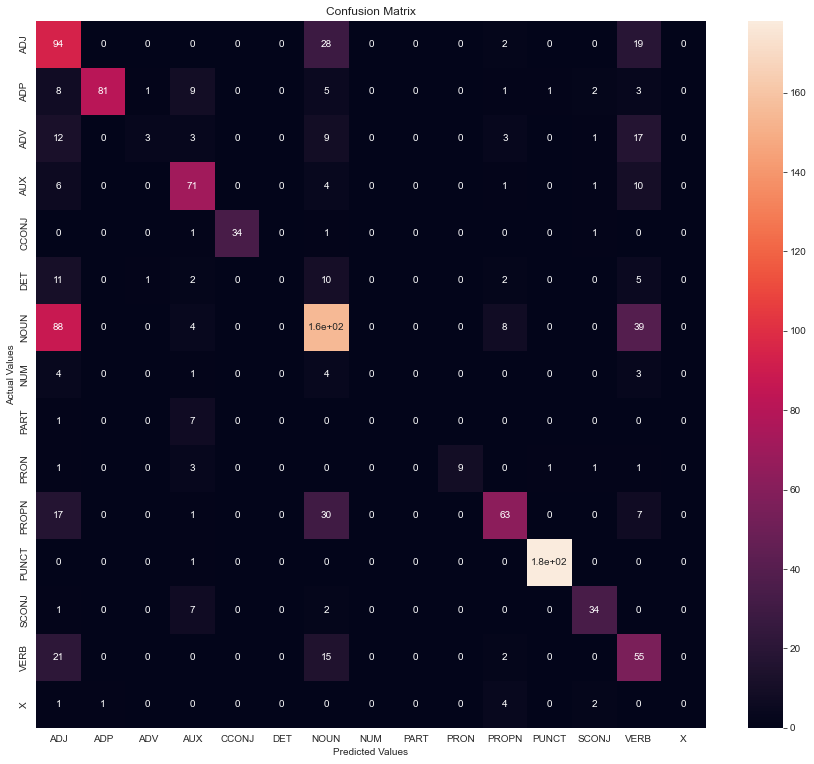

In [36]:
fileName = "final"

classes = np.union1d(np.unique(actual), np.unique(predicted))
cm = metrics.confusion_matrix(actual, predicted)
cm_df = pd.DataFrame(cm,
                     index = classes,
                     columns = classes)
#Plotting the confusion matrix
plt.figure(figsize=(15,13))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

### Primer predikcije UPOS etiketa na nivou reči datih u rečenici

In [37]:
sentence = Sentence('Srbija je tokom bombardovanja 1990 devedesetih izgubila mnoge kulturne znamenitosti.')

# predviđanje etiketa
model.predict(sentence)

print(sentence.to_tagged_string())

Sentence: "Srbija je tokom bombardovanja 1990 devedesetih izgubila mnoge kulturne znamenitosti ." → ["Srbija"/PROPN, "je"/AUX, "tokom"/ADJ, "bombardovanja"/NOUN, "1990"/PROPN, "devedesetih"/ADJ, "izgubila"/NOUN, "mnoge"/VERB, "kulturne"/ADJ, "znamenitosti"/NOUN, "."/PUNCT]


In [11]:
print(metrics.classification_report(actual,predicted))

NameError: name 'actual' is not defined

In [21]:
text_file = open(f"resources/model_library/{fileName}/{fileName}_report.txt", "w")
text_file.write(metrics.classification_report(actual,predicted))
text_file.close()

C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\vladimir\anaconda3\envs\ML3\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
